In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

Generating some positively correlated data with a clear trend

In [3]:
np.random.seed(42)

n = 30

x = np.arange(n)
y = x + 20 * np.random.random(n)

df = pd.DataFrame({"x": scale(x), "y": scale(y)})

<IPython.core.display.Javascript object>

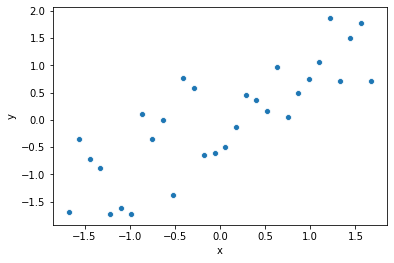

<IPython.core.display.Javascript object>

In [4]:
sns.scatterplot("x", "y", data=df)
plt.show()

We're going to fit a linear regression. Thanks to minimizing error and the nature of this data, the line should put about half of the points above/below the line.  We'll use this to create labels for the data points (class 0 & 1).  Then we'll fit an `SVC`, the data should be perfectly separable and with a high value of `C`, the decision boundary should match the line drawn by OLS.

In [5]:
X = df[["x"]]
y = df["y"]

lm = LinearRegression()
lm.fit(X, y)

# Storing predictions to draw line
df["lm_y"] = lm.predict(X)

# Create labels based on sign of residual
resid = df["lm_y"] - y
df["label_bin"] = (resid > 0).astype(int)
df["label"] = df["label_bin"]
df.loc[df["label"] == 0, "label"] = -1

<IPython.core.display.Javascript object>

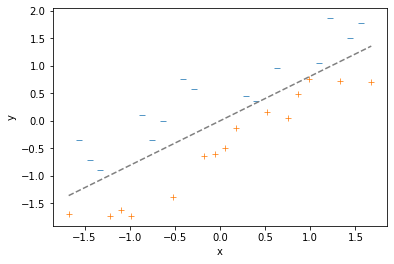

<IPython.core.display.Javascript object>

In [6]:
sns.scatterplot("x", "y", hue="label_bin", style="label", markers=["_", "+"], data=df)
plt.plot(df["x"], df["lm_y"], "--", c="gray", label="OLS")
plt.legend().remove()
plt.show()

Let's go ahead and fit an SVC.  We have some points very close to the OLS line.  In order for the decision boundary of SVC to match the OLS line we need it to have a high `C`.

In [7]:
X = df[["x", "y"]]
y = df["label_bin"]

svc = SVC(C=100000, kernel="linear")
svc.fit(X, y)

svc.coef_

array([[ 13.46222138, -14.62333034]])

<IPython.core.display.Javascript object>

In [8]:
svc.intercept_

array([-1.16876035])

<IPython.core.display.Javascript object>

Our formula for prediction:

$$-1.17 + (13.46) * x + (-14.62) * y$$

If we plug in our features and we get out a number greater than 0, we will predict the positive class; a number less than 0 and we will predict the negative class.

Note, this is our threshold for classification.  SVC actually tried to do better. More on that below.

For linear SVC, interpreting coefficients is not the same as in linear or logistic regression.  There are some things we can take away:
* The objective of SVC is minimize these coefficients as long as it doesn't lead to poor predictions, this means the size of the coefficients is an indication of importance.
* The sign can give some indication of which class the feature is associated with, for example `y` has a negative coefficient and if you inspect the plot you'll see that a higher y is associated with the negative class (class 0).  However, take note that this style of interpretation doesn't perfectly hold for `x`'s coefficient (we don't see much indication of class based on `x`)

In [9]:
# Extract coefficients and intercept
w1 = svc.coef_[0][0]
w2 = svc.coef_[0][1]
b = svc.intercept_[0]

# Apply formula
df["pred"] = b + w1 * df["x"] + w2 * df["y"]

# Convert outputted value to label
df["pred_label"] = (df["pred"] > 0).astype(int)
df.loc[df["pred_label"] == 0, "pred_label"] = -1

# Prove zero mistakes
(df["label"] != df["pred_label"]).sum()

0

<IPython.core.display.Javascript object>

The objective of SVC is to minimize the following:

$$\frac{1}{2}||w||^2 + C \sum_i{max(0, 1 - y_i(w^Tx_i + b))}$$ 

Dictionary:
* $w$ is the coefficients
* $||w||$ is the magnitude of the coefficients
* $C$ is a hyperparameter to address how much slack is allowed to misclassify training samples (too high and chance of overfitting)
* $x_i$ is a training sample (feature vector)
* $y_i$ is a training sample's true label
* $b$ is the intercept

Translations:

* $\frac{1}{2}||w||^2$
    * Goal: Maximize margin
    * Minimizing this expression (given a constraint of perfectly separating the data) is mathematically equivalent to maximizing the margin between the support vectors.
    
    
* $C \sum_i{max(0, 1 - y_i(w^Tx_i + b))}$
    * Goal: Add a penaly for misclassifying training samples
    * $w^Tx_i + b$ is the formula we apply to predict new observations. Multiply the features by coefficients and add a constant.  If the result is above 0 we predict 1, otherwise we predict 0.
    * Lets say our true label ($y_i$) is 1 and $w^Tx_i + b$ evaluates to -2.  Then $max(0, 1 - (1)(-2))$ is 3 (adding some penalty for misclassifying).
    * Lets say our true label ($y_i$) is -1 and $w^Tx_i + b$ evaluates to -2.  Then $max(0, 1 - (-1)(-2))$ is 0 (adding no penalty for misclassifying).
    
    
------

Written out in code for our example.

In [10]:
def svc_objective(X, y, w, b, C):
    # 1/2 * ||w||^2
    weight_size = (1 / 2) * np.linalg.norm(w) ** 2

    # C * sum(max(0, 1−y(wt * xi + b)))

    # 1−y(wt * xi + b)
    penalties = 1 - y * (np.dot(X, w.T) + b)
    # max(0, penalties)
    penalties = np.clip(penalties, 0, np.inf)
    penalty = C * np.sum(penalties)

    value = weight_size + penalty

    return value, weight_size, penalty

<IPython.core.display.Javascript object>

In [11]:
X = df[["x", "y"]].values
y = df[["label"]].values

w = svc.coef_
b = svc.intercept_

C = 100000

value, margin, misclassifcation = svc_objective(X, y, w, b, C)

print(f"margin component: {margin:.2f}")
print(f"misclassifcation component: {misclassifcation:.2f}")
print(f"total objective: {value:.2f}")

margin component: 197.54
misclassifcation component: 133.60
total objective: 331.14


<IPython.core.display.Javascript object>

We technically didn't have any mistakes, but we classified based on being greater or less than `0`.  SVC's goal is to have all the negative observations have an outputted value `<= -1` and all the positive observations have an outputted value `>= 1`.  We had some observations with absolute values below 1 so we see some penalty here for it and our very large `C` scaled up the penalty a lot.

---

Compare to other coefficients.  We should always see a higher number for the final output in this case.

In [13]:
w_random = np.random.normal(0, 20, size=(1, 2))

value, margin, misclassifcation = svc_objective(X, y, w_random, b, C)

print(f"coefficients used: {w_random}\n")

print(f"margin component: {margin:.2f}")
print(f"misclassifcation component: {misclassifcation:.2f}")
print(f"total objective: {value:.2f}")

coefficients used: [[-40.53439231  22.38847223]]

margin component: 1072.14
misclassifcation component: 53426295.47
total objective: 53427367.61


<IPython.core.display.Javascript object>

We can minimize the first portion of the objective by using 0s as coefficients, but this comes with a big increase in the second half of the objective that focuses on mistakes.

In [14]:
w_zero = np.array([[0, 0]])

value, margin, misclassifcation = svc_objective(X, y, w_zero, b, C)

print(f"coefficients used: {w_zero}\n")

print(f"margin component: {margin:.2f}")
print(f"misclassifcation component: {misclassifcation:.2f}")
print(f"total objective: {value:.2f}")

coefficients used: [[0 0]]

margin component: 0.00
misclassifcation component: 3253140.52
total objective: 3253140.52


<IPython.core.display.Javascript object>

If you don't care about mistakes you could set `C` low.

In [15]:
w_zero = np.array([[0, 0]])
C_low = 0.01

value, margin, misclassifcation = svc_objective(X, y, w_zero, b, C_low)

print(f"coefficients used: {w_zero}\n")

print(f"margin component: {margin:.2f}")
print(f"misclassifcation component: {misclassifcation:.2f}")
print(f"total objective: {value:.2f}")

coefficients used: [[0 0]]

margin component: 0.00
misclassifcation component: 0.33
total objective: 0.33


<IPython.core.display.Javascript object>

As far as SVC thinks, this is a better solution given the parameters.  We told it to minimze the coefficients and that we don't care about misclassifications.  This just shows the importance of optimizing your value of `C`.  SVC's goal is to minimize the objective, we need to make sure it's objective matches ours.

What about kernels?

Demos show plots of the higher dimensional space, but to show that plot you need to actually calculate all that new data.  In practice, the kernels are directly incorporated into the objective without the actual need to calculate the full kernel space.  

This requires rewriting the objective in a different form which won't be done here. In the end we are still minimzing our objective function which means we are after a combination of maximizing the margin and minimizing mistakes in the training data.